In [6]:
import gym
import torch
import random
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from agent import DoubleDQNAgent
import matplotlib.pyplot as plt



In [7]:
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
# CartPole-v1 
game = 'CartPole-v1'


In [9]:


# Paramètres de l'agent et de l'environnement
EPISODES = 5000                   # Nombre d'épisodes à exécuter
MAX_TIMESTEPS = 400               # Limite de temps pour un épisode
STATE_SIZE = 4                    # Taille de l'état de l'environnement
ACTION_SIZE = 2                   # Nombre d'actions possibles
BATCH_SIZE = 64                   # Taille du mini-batch échantillonné
GAMMA = 0.99                      # Taux d'escompte pour les récompenses futures
EPSILON = 1.0                     # Initialisation de l'exploration
EPSILON_DECAY = 0.997             # Taux de décroissance de l'exploration
EPSILON_MIN = 0.01                # Valeur minimum de l'exploration
LEARNING_RATE = 0.0001             # Taux d'apprentissage pour l'optimiseur Adam

# Instanciation de l'environnement et de l'agent
env = gym.make(game)
agent = DoubleDQNAgent(STATE_SIZE, ACTION_SIZE, BATCH_SIZE, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

plot_reward = []
plot_mean_reward = []
plot_eps = []

# Boucle d'entraînement
max_reward = 0
consecutive_success = 0
for episode in range(EPISODES):
    # Réinitialisation de l'environnement et de l'état initial de l'agent
    state = env.reset()
    done = False
    total_reward = 0
    t = 0

    # Boucle pour un épisode
    while not done and t < MAX_TIMESTEPS:
        # Sélection d'une action, exécution de l'action et observation des résultats
        action = agent.act(state)
        next_state, reward, done,_ = env.step(action)

        # Mise en mémoire tampon de l'expérience
        agent.remember(state, action, reward, next_state, done)

        # Entraînement de l'agent après une période fixe
        if t % 10 == 0:
            agent.train()

        # Mise à jour de l'état de l'agent et du cumul de récompense
        state = next_state
        total_reward += reward
        t += 1
    
    plot_eps.append(agent.epsilon*400)
    plot_reward.append(total_reward)
    plot_mean_reward.append(np.mean(plot_reward[-25:]))

    # Mise à jour de l'exploration
    agent.update_epsilon()

    # Impression des résultats de l'épisode
    print("Episode: {}/{}, timesteps: {}, reward: {:.2f}, epsilon: {:.2f}, consecutive successful episodes: {}".format(episode+1, EPISODES, t, total_reward, agent.epsilon,consecutive_success))
    
    # Vérification de l'early stopping
    if total_reward >= MAX_TIMESTEPS - (MAX_TIMESTEPS/4) or np.mean(plot_mean_reward[-10:]) >=200:
        consecutive_success += 1
        if consecutive_success >= 50:
            print("Solved after {} consecutive successful episodes!".format(consecutive_success))
            break
    else:
        consecutive_success = 0

    # Sauvegarde du modèle à la fin de l'entraînement
    if total_reward > max_reward:
        max_reward = total_reward
        torch.save(agent.model.state_dict(), f"{game}_ddqn.pth")



Episode: 1/5000, timesteps: 28, reward: 28.00, epsilon: 1.00, consecutive successful episodes: 0
Episode: 2/5000, timesteps: 49, reward: 49.00, epsilon: 0.99, consecutive successful episodes: 0
Episode: 3/5000, timesteps: 14, reward: 14.00, epsilon: 0.99, consecutive successful episodes: 0
Episode: 4/5000, timesteps: 11, reward: 11.00, epsilon: 0.99, consecutive successful episodes: 0
Episode: 5/5000, timesteps: 16, reward: 16.00, epsilon: 0.99, consecutive successful episodes: 0
Episode: 6/5000, timesteps: 11, reward: 11.00, epsilon: 0.98, consecutive successful episodes: 0
Episode: 7/5000, timesteps: 26, reward: 26.00, epsilon: 0.98, consecutive successful episodes: 0
Episode: 8/5000, timesteps: 10, reward: 10.00, epsilon: 0.98, consecutive successful episodes: 0
Episode: 9/5000, timesteps: 20, reward: 20.00, epsilon: 0.97, consecutive successful episodes: 0
Episode: 10/5000, timesteps: 28, reward: 28.00, epsilon: 0.97, consecutive successful episodes: 0
Episode: 11/5000, timesteps: 

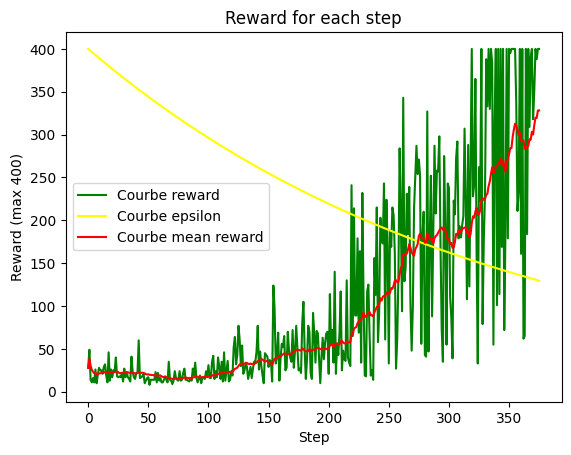

In [10]:
abscisse = np.arange(0,len(plot_reward))
# Tracer la courbe
plt.plot(abscisse, plot_reward, color='green', label='Courbe reward')

plt.plot(abscisse, plot_eps, color='yellow', label='Courbe epsilon')

plt.plot(abscisse, plot_mean_reward, color='red', label='Courbe mean reward')


# Ajouter des labels et une légende
plt.xlabel('Step')
plt.ylabel(f'Reward (max {MAX_TIMESTEPS})')
plt.title('Reward for each step')
plt.legend()

# Afficher le graphique
plt.show()

In [12]:

# Instanciation de l'environnement et de l'agent
env = gym.make(game)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DoubleDQNAgent(state_size, action_size, batch_size=32, gamma=0.99, epsilon=0, epsilon_decay=0, epsilon_min=0, is_test=True)
model_path = f"{game}_ddqn.pth"
agent.model.load_state_dict(torch.load(model_path))

# Boucle de jeu
for i_episode in range(5):
    state = env.reset()
    total_reward = 0
    for t in range(200):
        # Affichage du rendu graphique de l'environnement
        env.render()
        
        action = agent.act(state)

        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        state = next_state
        
        
        if t == 199:
            print("finish with reward : {}".format(total_reward))
            break
        elif done:
            print("Episode finished after {} timesteps. Total reward: {}".format(t+1, total_reward))
            break


# Fermeture de l'environnement
env.close()


finish with reward : 200.0
finish with reward : 200.0
finish with reward : 200.0
finish with reward : 200.0
finish with reward : 200.0
